# Objectives

* Formalize win probability model
* Estimate and predict multinomial logitistic regresison models
* Implement Bayes' rule

## NHL In-Game Win Probability Model

Estimate the following model:
    
$$ p(hw_g| score_{g,t} ) = \frac{p(hg_g| score_{g,t} ) p(hw_g)}{ p(score_{g,t} | hw_g) p(hw_g) +  p(score_{g,t} | \bar{hw_g}) p( \bar{hw_g}) } $$

where,

* $(hw_g| score_{g,t})$: posterior probability of a home team win given the score differential game state
* $p(hw_g$: prior probability of a home team win
* $p(score_{g,t} |hw_g)$ and $p(score_{g,t}  | \bar{hw_g})$: inverse conditional probabilities

In [116]:
# modules
import sys
import os
import pandas
import numpy
import datetime, time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import hist, show
import scipy
import statsmodels.api as sm

pandas.set_option("display.max_rows", 35)
pandas.set_option("display.max_columns", 50)
pandas.set_option("display.max_colwidth", 200)

In [117]:
dh = pandas.read_csv('2014Events.csv')
# smaller development dataframe to decrease execution time
#dh = dh[dh['gamenumber']<=20200]


In [118]:
print len(dh)
print dh.columns
print dh.dtypes
print dh.head()
print dh['teamcode'].value_counts()

315318
Index([u'gamedate', u'season', u'gamenumber', u'period', u'eventtimefromzero',
       u'eventnumber', u'advantagetype', u'teamcode', u'playernumber',
       u'isthome', u'name', u'position', u'toirank', u'eventtype', u'zone',
       u'tgoals', u'ogoals', u'vteamcode', u'hteamcode', u'winteamcode',
       u'isOTWin', u'isSOWin'],
      dtype='object')
gamedate              object
season                 int64
gamenumber             int64
period                 int64
eventtimefromzero      int64
eventnumber            int64
advantagetype         object
teamcode              object
playernumber           int64
isthome                int64
name                  object
position              object
toirank              float64
eventtype             object
zone                  object
tgoals                 int64
ogoals                 int64
vteamcode             object
hteamcode             object
winteamcode           object
isOTWin                int64
isSOWin                int64
dt

In [119]:
dh['secStart'] = ((dh['period']-1)*1200 + dh['eventtimefromzero'])
dh = dh.sort_values(by=['season', 'gamenumber', 'secStart'], ascending=[1, 1, 1])
dh['minStart'] = (dh['secStart']/60).astype(int)

In [120]:
# in-game information relative to home team
dh['homeScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 1 else x['ogoals'], axis=1)
dh['awayScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 0 else x['ogoals'], axis=1)
dh['homeSM']    = dh['homeScore'] - dh['awayScore']
dh['homeWin'] = dh.apply(lambda x: 1 if x['winteamcode'] == x['hteamcode'] else 0, axis=1)
dh['homeSM'].value_counts()

 0    120943
 1     59306
-1     54637
 2     27469
-2     21743
 3     12387
-3      8195
 4      4851
-4      2936
 5      1592
-5       580
 6       314
-6       288
-7        35
 7        24
-8        18
Name: homeSM, dtype: int64

In [121]:
# get game results
df = pandas.DataFrame(dh.groupby(['gamenumber'], axis=0,  as_index=False)['homeSM'].last())
df = df.rename(columns={'homeSM' : 'finalHSM'})
df['finalHSM'].value_counts()

 0    215
 1    196
-1    174
 3    138
 2    125
-2    121
-3     95
 4     50
-4     42
 5     26
-5      8
 6      8
-6      2
-7      2
Name: finalHSM, dtype: int64

In [122]:
# merge game and game-event data
dh = pandas.merge(dh, df, left_on='gamenumber', right_on='gamenumber', how='outer')
print dh.head(2)

    gamedate  season  gamenumber  period  eventtimefromzero  eventnumber  \
0  10/8/2014    2014       20001       1                  0            1   
1  10/8/2014    2014       20001       1                 19            3   

  advantagetype teamcode  playernumber  isthome              name position  \
0           NaN      MTL            51        0  DESHARNAIS_DAVID        C   
1            EV      MTL            51        0  DESHARNAIS_DAVID        C   

   toirank eventtype zone  tgoals  ogoals vteamcode hteamcode winteamcode  \
0      2.0       FAC    N       0       0       MTL       TOR         MTL   
1      2.0      MISS    O       0       0       MTL       TOR         MTL   

   isOTWin  isSOWin  secStart  minStart  homeScore  awayScore  homeSM  \
0        0        0         0         0          0          0       0   
1        0        0        19         0          0          0       0   

   homeWin  finalHSM  
0        0        -1  
1        0        -1  


In [123]:
# in-game information relative to home team
dh['homeScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 1 else x['ogoals'], axis=1)
dh['awayScore'] = dh.apply(lambda x: x['tgoals'] if x['isthome'] == 0 else x['ogoals'], axis=1)
dh['homeSM']    = dh['homeScore'] - dh['awayScore']
dh['homeWin'] = dh.apply(lambda x: 1 if x['winteamcode'] == x['hteamcode'] else 0, axis=1)
dh['homeSM'].value_counts()

 0    120943
 1     59306
-1     54637
 2     27469
-2     21743
 3     12387
-3      8195
 4      4851
-4      2936
 5      1592
-5       580
 6       314
-6       288
-7        35
 7        24
-8        18
Name: homeSM, dtype: int64

In [124]:
# create game-minute observations
dm = pandas.DataFrame(dh.groupby(['gamenumber', 'minStart'], axis=0, as_index=False).first())
dm = dm[dm['minStart']!=0]
dm = dm[dm['period']<=3]

In [125]:
# calculate team win percentages by date for game specific priors
dr = pandas.DataFrame()
ds = dh[['gamedate', 'gamenumber', 'hteamcode', 'vteamcode', 'winteamcode', 'isOTWin', 'isSOWin']].groupby(['gamenumber']).first().reset_index()
teamList = ds['hteamcode'].unique()
print teamList

['TOR' 'BOS' 'CGY' 'LA' 'BUF' 'PHI' 'PIT' 'WSH' 'DET' 'TB' 'STL' 'NSH'
 'DAL' 'MIN' 'EDM' 'ARI' 'CAR' 'FLA' 'NYI' 'CBJ' 'CHI' 'COL' 'VAN' 'SJ'
 'NYR' 'MTL' 'OTT' 'WPG' 'ANA' 'NJ']


In [126]:
# for loop to calu
for team in teamList:
    du = ds[(ds['hteamcode'] == team) | (ds['vteamcode'] == team)].copy()
    du.loc[::,'team'] = team
    du.loc[::,'wins']   = du.apply(lambda x: 1 if x['winteamcode'] == team else 0, axis=1).shift(1).cumsum()
    du.loc[::,'loss']   = du.apply(lambda x: 1 if x['winteamcode'] != team else 0, axis=1).shift(1).cumsum()
    dr = dr.append(du)
    print 'completed loop for ' + team
dr.loc[::, 'winPer'] = dr['wins'] /(dr['wins'] + dr['loss'])

completed loop for TOR
completed loop for BOS
completed loop for CGY
completed loop for LA
completed loop for BUF
completed loop for PHI
completed loop for PIT
completed loop for WSH
completed loop for DET
completed loop for TB
completed loop for STL
completed loop for NSH
completed loop for DAL
completed loop for MIN
completed loop for EDM
completed loop for ARI
completed loop for CAR
completed loop for FLA
completed loop for NYI
completed loop for CBJ
completed loop for CHI
completed loop for COL
completed loop for VAN
completed loop for SJ
completed loop for NYR
completed loop for MTL
completed loop for OTT
completed loop for WPG
completed loop for ANA
completed loop for NJ


In [127]:
# merge 
dr = dr[['gamenumber', 'team', 'winPer']]
dm = pandas.merge(dm,dr,left_on=['gamenumber', 'hteamcode'], right_on=['gamenumber', 'team'])
dm = dm.rename(columns={'winPer':'homeWinPer'})
dm = pandas.merge(dm,dr,left_on=['gamenumber', 'vteamcode'], right_on=['gamenumber', 'team'])
dm = dm.rename(columns={'winPer':'awayWinPer'})
dm = dm.drop(['team_x', 'team_y'], axis=1)

print dm.head(2)
# completed minute-level data'

   gamenumber  minStart   gamedate  season  period  eventtimefromzero  \
0       20001         1  10/8/2014    2014       1                 65   
1       20001         2  10/8/2014    2014       1                132   

   eventnumber advantagetype teamcode  playernumber  isthome             name  \
0            7            EV      MTL            79        0    MARKOV_ANDREI   
1           18            EV      MTL            28        0  BEAULIEU_NATHAN   

  position  toirank eventtype zone  tgoals  ogoals vteamcode hteamcode  \
0        D      1.0       HIT    D       0       0       MTL       TOR   
1        D      6.0      MISS    O       0       0       MTL       TOR   

  winteamcode  isOTWin  isSOWin  secStart  homeScore  awayScore  homeSM  \
0         MTL        0        0        65          0          0       0   
1         MTL        0        0       132          0          0       0   

   homeWin  finalHSM  homeWinPer  awayWinPer  
0        0        -1         NaN        

In [128]:
### score margin summary analysis
ds = pandas.DataFrame()
ds['trDScLaActu'] = dm[dm['homeWin']==1].groupby(['minStart'])['homeSM'].agg({'mean' : numpy.mean})
ds['faDScLaActu'] = dm[dm['homeWin']==0].groupby(['minStart'])['homeSM'].agg({'mean' : numpy.mean})
print ds

    trDScLaActu  faDScLaActu
0           NaN          NaN
1      0.012520    -0.012750
2      0.039124    -0.020183
3      0.057994    -0.031308
4      0.090062    -0.049180
5      0.123245    -0.096715
6      0.160436    -0.117100
7      0.212168    -0.130275
8      0.232919    -0.177331
9      0.286604    -0.233577
10     0.319249    -0.253235
11     0.340125    -0.262385
12     0.361801    -0.280734
13     0.387147    -0.276051
14     0.415625    -0.294872
15     0.440945    -0.324818
16     0.462500    -0.344954
..          ...          ...
43     1.160126    -1.046211
44     1.202194    -1.053704
45     1.240945    -1.103512
46     1.289100    -1.159259
47     1.320312    -1.161111
48     1.339036    -1.191882
49     1.364207    -1.230483
50     1.412975    -1.261993
51     1.412598    -1.248134
52     1.469579    -1.285714
53     1.494488    -1.289425
54     1.531981    -1.309963
55     1.542320    -1.337711
56     1.568075    -1.353704
57     1.643533    -1.384899
58     1.69073

## plot

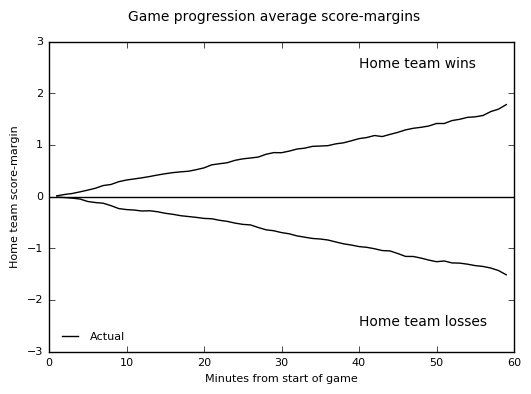

In [129]:
# create index to plot
ds = ds.reset_index()
ds = ds.rename(columns={'index' : 'minStart'})
ds = ds[ds['minStart']!=0]

# line plot
tempName = 'condLeagueScoreMarginsActu.pdf'
tempFile = os.path.join(tempName)

fig, ax0 = plt.subplots(facecolor='white')
ax0.plot(ds.index, ds['trDScLaActu'], label='Actual'  , marker='', linestyle='-', linewidth=1, color='black')
ax0.plot(ds.index, ds['faDScLaActu'], label='', marker='', linestyle='-', linewidth=1, color='black')
ax0.set_title('', fontsize=8)
ax0.set_xlabel('Minutes from start of game', fontsize=8)
ax0.tick_params(axis='both', labelsize=8)
ax0.set_ylabel('Home team score-margin', fontsize=8)
ax0.set_ylim([-3, 3])
ax0.axhline(y=0,xmin=0,xmax=60,c="black",linewidth=1.0, linestyle='-', zorder=0)
legend = ax0.legend(loc='lower left', shadow=False, fontsize=8, frameon=False)
ax0.text(40,2.5, 'Home team wins', fontsize=10)
ax0.text(40,-2.5, 'Home team losses', fontsize=10)
fig.suptitle("Game progression average score-margins", fontsize=10)
plt.savefig(tempFile)
#plt.close('all')
plt.show()

In [130]:
### estimate inverse conditional probabilities; p(HSM|TR)

# adjust score margin states
dm['homeSM'] = dm.apply(lambda x: 3  if x['homeSM'] > 3 else  x['homeSM'], axis=1)
dm['homeSM'] = dm.apply(lambda x: -3 if x['homeSM'] < -3 else x['homeSM'], axis=1)
dm['homeSM'].describe()

# create win and lose specific data sets
dw = dm[dm['homeWin']==1]
dl = dm[dm['homeWin']==0]

In [131]:
# Multinomial Logitisitc regression
trMNL   = sm.MNLogit(dw['homeSM'], sm.add_constant(dw['minStart'])).fit()
trMNL.summary()

faMNL   = sm.MNLogit(dl['homeSM'], sm.add_constant(dl['minStart'])).fit()
faMNL.summary()

Optimization terminated successfully.
         Current function value: 1.469714
         Iterations 9
Optimization terminated successfully.
         Current function value: 1.432184
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                 homeSM   No. Observations:                32095
Model:                        MNLogit   Df Residuals:                    32083
Method:                           MLE   Df Model:                            6
Date:                Wed, 15 Mar 2017   Pseudo R-squ.:                 0.05535
Time:                        14:36:36   Log-Likelihood:                -45966.
converged:                       True   LL-Null:                       -48659.
                                        LLR p-value:                     0.000
==============================================================================
 homeSM=-2       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.7614      0.079     22.292      0.000         1.607     1.916
minStart      -0.0314      0.002    -17.600      0.000        -0.035    -0.028
------------------------------------------------------------------------------
 homeSM=-1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          3.1709      0.073     43.550      0.000         3.028     3.314
minStart      -0.0513      0.002    -31.147      0.000        -0.054    -0.048
------------------------------------------------------------------------------
  homeSM=0       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          4.4692      0.072     62.268      0.000         4.329     4.610
minStart      -0.0870      0.002    -52.279      0.000        -0.090    -0.084
------------------------------------------------------------------------------
  homeSM=1       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.7866      0.077     36.006      0.000         2.635     2.938
minStart      -0.0730      0.002    -38.733      0.000        -0.077    -0.069
------------------------------------------------------------------------------
  homeSM=2       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8390      0.111      7.544      0.000         0.621     1.057
minStart      -0.0684      0.003    -22.126      0.000        -0.074    -0.062
------------------------------------------------------------------------------
  homeSM=3       coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.3667      0.261     -5.234      0.000        -1.878    -0.855
minStart      -0.0634      0.008     -8.283      0.000        -0.078    -0.048
==============================================================================
"""

In [132]:
# Predict probabilities of score states
de1 = pandas.DataFrame(trMNL.predict(sm.add_constant(dm['minStart'])))
de0 = pandas.DataFrame(faMNL.predict(sm.add_constant(dm['minStart'])))
de = de1/de0

In [133]:
# change column names to be consistent with score states
de.columns = de.columns - 3
print de.head()

         -3        -2        -1         0         1         2         3
0  0.265551  0.410975  0.540709  0.984085  1.616993  3.317940  6.901401
1  0.248733  0.395904  0.532354  0.981979  1.648922  3.433989  7.329717
2  0.232966  0.381363  0.524095  0.979816  1.681377  3.553877  7.784132
3  0.218184  0.367333  0.515932  0.977598  1.714364  3.677721  8.266202
4  0.204327  0.353797  0.507865  0.975322  1.747887  3.805640  8.777573


In [134]:
# merge inverse conditional data frames
dm = pandas.merge(dm, de, left_index=True,right_index=True)

In [135]:
## obtained game-minute specific inverse conditional
# create indicator variables
dm['d3'] = dm.apply(lambda x: 1 if x['homeSM']==-3 else 0, axis=1)
dm['d2'] = dm.apply(lambda x: 1 if x['homeSM']==-2 else 0, axis=1)
dm['d1'] = dm.apply(lambda x: 1 if x['homeSM']==-1 else 0, axis=1)
dm['ti'] = dm.apply(lambda x: 1 if x['homeSM']==0  else 0, axis=1)
dm['u1'] = dm.apply(lambda x: 1 if x['homeSM']==1  else 0, axis=1)
dm['u2'] = dm.apply(lambda x: 1 if x['homeSM']==2  else 0, axis=1)
dm['u3'] = dm.apply(lambda x: 1 if x['homeSM']==3  else 0, axis=1)

# multiple inverse conditionals and indicators
dm['invCond']      = dm['d3']*dm[-3] + dm['d2']*dm[-2] + dm['d1']*dm[-1] + dm['ti']*dm[0] + dm['u1']*dm[1] + dm['u2']*dm[2] + dm['u3']*dm[3]

In [136]:
# set prior odds and probabilities
dm['priorProb']     = (dm['homeWinPer'] / (dm['homeWinPer'] + dm['awayWinPer'])).fillna(0.5)
dm['priorOdds']     = (dm['homeWinPer'] / dm['awayWinPer']).fillna(1.0)

In [137]:
dm.head(2)

,gamenumber,minStart,gamedate,season,period,eventtimefromzero,eventnumber,advantagetype,teamcode,playernumber,isthome,name,position,toirank,eventtype,zone,tgoals,ogoals,vteamcode,hteamcode,winteamcode,isOTWin,isSOWin,secStart,homeScore,awayScore,homeSM,homeWin,finalHSM,homeWinPer,awayWinPer,-3,-2,-1,0,1,2,3,d3,d2,d1,ti,u1,u2,u3,invCond,priorProb,priorOdds
0,20001,1,10/8/2014,2014,1,65,7,EV,MTL,79,0,MARKOV_ANDREI,D,1.0,HIT,D,0,0,MTL,TOR,MTL,0,0,65,0,0,0,0,-1,NaN,NaN,0.265551,0.410975,0.540709,0.984085,1.616993,3.317940,6.901401,0,0,0,1,0,0,0,0.984085,0.5,1.0
1,20001,2,10/8/2014,2014,1,132,18,EV,MTL,28,0,BEAULIEU_NATHAN,D,6.0,MISS,O,0,0,MTL,TOR,MTL,0,0,132,0,0,0,0,-1,NaN,NaN,0.248733,0.395904,0.532354,0.981979,1.648922,3.433989,7.329717,0,0,0,1,0,0,0,0.981979,0.5,1.0


In [138]:
## calculate posterior odds and probabilities (Bayes Rule)
dm['postOdds']      =  dm['priorOdds'] * dm['invCond']
dm['postProb']      =  dm['postOdds'] / (1 + dm['postOdds'])

In [139]:
## game-specific plot of in-game win probabilities
# set gamenumber
d1 = dm[dm['gamenumber']==20800]
len(d1)
print d1[['gamenumber', 'minStart', 'homeSM', 'priorProb', 'postProb' ]]

       gamenumber  minStart  homeSM  priorProb  postProb
46433       20800         1       0   0.416725  0.412831
46434       20800         2       0   0.416725  0.412311
46435       20800         3      -1   0.416725  0.272433
46436       20800         4      -1   0.416725  0.269332
46437       20800         5      -1   0.416725  0.266242
46438       20800         6      -1   0.416725  0.263162
46439       20800         7      -1   0.416725  0.260093
46440       20800         8      -1   0.416725  0.257034
46441       20800         9      -1   0.416725  0.253987
46442       20800        10      -1   0.416725  0.250951
46443       20800        11      -2   0.416725  0.167716
46444       20800        12      -2   0.416725  0.162478
46445       20800        13      -2   0.416725  0.157364
46446       20800        14      -2   0.416725  0.152373
46447       20800        15      -2   0.416725  0.147504
46448       20800        16      -1   0.416725  0.233000
46449       20800        17    

In [140]:
print "date, away team, home team"
print d1.iloc[0]['gamedate']
print d1.iloc[0]['vteamcode']
print d1.iloc[0]['hteamcode']

date, away team, home team
2/10/2015
NYR
TOR


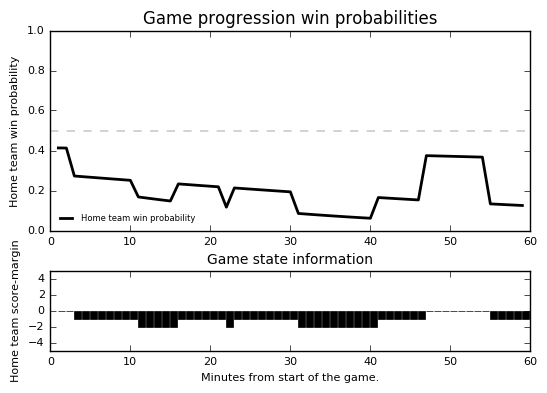

completed plot


In [141]:
# plot parameters
plt.rc('axes', grid=False)

width = 0.001
space = width + 0.10
left, width = 0.1, 0.8
rect1 = [left, 0.4, width, 0.5]
rect2 = [left, 0.1, width, 0.2]

fig = plt.figure(facecolor='white')
ax1 = fig.add_axes(rect1, axisbg='w')
ax2 = fig.add_axes(rect2, axisbg='w', sharex=ax1)
ax1.tick_params(axis='y', labelsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax1.set_ylim([0,1])
ax2.set_ylim([-5,5])
ax1.set_xlim([0,60])


# ig.suptitle(gameTitle, fontsize=12)
ax1.set_title("Game progression win probabilities", fontsize=12)
ax1.set_ylabel('Home team win probability', fontsize=8)
ax2.set_title('Game state information', fontsize=10, multialignment='center')
ax2.set_ylabel('Home team score-margin', fontsize=8, multialignment='center')
ax2.set_xlabel('Minutes from start of the game.', fontsize=8)

# plot lines
ax1.plot(d1['minStart'], d1['postProb']  , marker='', linestyle='-' , linewidth=2, color='black',  label='Home team win probability')

ax1.axhline(y=.5 ,c="black",linewidth=0.25, linestyle='--', zorder=0)
ax2.bar(d1['minStart'] , d1['homeSM'], width=width, color='black', edgecolor='black', linestyle='solid', linewidth=0.5)
legend = ax1.legend(loc='lower left', shadow=False, fontsize=6, frameon=False)

# save figure
plt.savefig("gn500.pdf", format='pdf')
#plt.close('all')
plt.show()
print 'completed plot'


In [142]:
## analysis complete